# Introduction

In the [Notebook](hello_poisson.ipynb) we introduced the basic process of
solving the Poisson problem with constant source. This seemed to work just fine,
but giving the prior existence of FEM solving software packages why have we gone
to all the additional work of implementing these methods inside of the Tensorflow
ecosystem? In this notebook we being to make this abit clearer by considering a
much more interesting class of models obtained by replacing the relatively
boring source of the previous examples with the tensorflow implementation of the
`GaussianProcess` class. That is we shall consider the solution of PDE systems of the
form

$$
\begin{align}
    -\nabla ( a(x) \nabla u(x) ) &= f(x) \qquad x \in \Omega \\
    u(x) &= g(x) \qquad x \in \partial\Omega \\
\end{align}
$$

where the source term, $f(x)$, and the boundary condition $g(x)$, are both
given independent Gaussian process priors.

$$
\begin{align}
    f(x) &\sim \mathcal{GP}(0, k_f), \\
    g(x) &\sim \mathcal{GP}(0, k_g)
\end{align}
$$

where the source function is now a mean zero Gaussian process with kernel function $k$.
We show that it is simple to put together this model, and for the cost of implementing
the FEM solver we have gained access to the full set of statistical and machine learning
models implemented in TensorFlow

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.backend.set_floatx('float64')
import tenfem
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.tri import Triangulation
from tenfem.layers import (AssembleStiffnessMatrix, AssembleLoadVector, SolveDirichletProblem,
                           TriangleMeshInterpolator)

tf_dtype = tf.float64
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers

tf.random.set_seed(321)

num_inducing_points = 10

### Domain creation
Before proceeding to define this part of the model, lets create our problem domain
$\Omega$, again we will use a simple example mesh which is the unit square
$\Omega = [0, 1] \times [0, 1]$. We will also rescale this domain to give our 
GP variables some "wiggle" room.

In [2]:
mesh = tenfem.mesh.examples.square(20, 20, dtype=tf_dtype)
# rescale the mesh a bit
mesh = tenfem.mesh.TriangleMesh(3. * mesh.nodes,
                                mesh.elements,
                                mesh.boundary_elements)
mesh.add_matplotlib_tri()

# Creating the GP model


## The kernel function
In this example we shall take the kernel function of our Gaussian process to be popular
exponentiated quadratic, or radial basis function (RBF) kernel

$$
    k(x, x') = \alpha^2 \exp\left(-\frac{1}{2} \sum_{d=1}^D (x_d - x'_d ) / \ell_d^2 \right)
$$

where $\alpha$ is the *amplitude* parameter, and $\ell$ is the *length-scale* parameter. 

We want to implement the GP model inside of the `tf.keras` functional API using the layers
created by the `tensorflow_probability` team. To do so we are going to need a layer whose
job is provide the kernel function to the Gaussian process. This layers job is to hold the
model parameters, and simple layer class to do this job taken from 
the [tfp examples]() is given below

In [3]:
class RBFKernelFn(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(RBFKernelFn, self).__init__(**kwargs)
        dtype = kwargs.get('dtype', None)

        self._amplitude = self.add_weight(
                initializer=tf.constant_initializer(0),
                dtype=dtype,
                name='amplitude')

        self._length_scale = self.add_weight(
                initializer=tf.constant_initializer(0.5),
                dtype=dtype,
                name='length_scale')

    @property
    def kernel(self):
        return tfp.math.psd_kernels.ExponentiatedQuadratic(
          amplitude=tf.nn.softplus(0.1 * self._amplitude),
          length_scale=tf.nn.softplus(0.1 * self._length_scale))

## `VariationalGaussianProcess`

Read more about these process at ... first we are just going to define a function
to build these layers, and then give a bit more of a recap of what is going on

In [4]:
def build_gp_layer(kernel_fn='RBF'):
    """ Simple function to quickly build a SVGP layer. """
    if kernel_fn != 'RBF':
        raise NotImplementError('Add more kernel functions!')

    # select the initial inducing points uniformly from the mesh node
    z_indices = np.random.choice(mesh.interior_node_indices.numpy(), 
                                 size=num_inducing_points, 
                                 replace=False)
    z = mesh.nodes.numpy()[z_indices]

    # initialize q(u) at the prior
    kernel_provider = RBFKernelFn(dtype=tf.float64)
    kzz = kernel_provider.kernel.matrix(z, z)
    scale = tf.linalg.cholesky(kzz).numpy()

    gp_layer = tfp.layers.VariationalGaussianProcess(
        num_inducing_points=num_inducing_points,
        kernel_provider=RBFKernelFn(),
        event_shape=[1],
        inducing_index_points_initializer=tf.constant_initializer(z),
        variational_inducing_observations_scale_initializer=tf.constant_initializer(scale),
        jitter=1e-4)
    return gp_layer

A Gaussian process determines the distribution of finite samples 
$\mathbf{f} = (f(\mathbf{x}_1), \ldots, f(\mathbf{x}_n) )$, a sparse
variational Gaussian process introduces an additional set of 
*inducing variables* denoted by $\mathbf{u}$ with distribution
$q(\mathbf{u})$ and then approximates the distribution over the
complete set of $\mathbb{f}$ by the factorised

$$
    p(\mathbf{f}, \mathbf{u}) = 
    p(\mathbf{f} \mid \mathbf{u}) q(\mathbf{u}).
$$

For Gaussian observations the parameters of $q(\mathbf{u})$ can
be determined analytically. For more complex models these are
instead freely optimised, in which case we specify

$$
    q(\mathbf{u}) = \mathcal{N}(\mathbf{u} \mid \mathbf{m}, \mathbf{LL}^{\top})
$$

where $\mathbf{L}$ is a lower-triangular matrix. For
`num_inducing_points = M` this is a total of 
$M + M(M+1)/2$ parameters.

In the examples below we use the
*inducing points variables* which are additional samples of the
process $f(\mathbf{x})$ drawn at locations 
$\mathbf{Z} = \{ \mathbf{z}_m \}_{m=1}^M$. This gives the
following set of parameters

* $\mathbf{Z}$ -- the `inducing_point_locations`
* $\mathbf{m}$ -- the `variational_inducing_observations_loc`
* $\mathbf{L}$ -- the `variational_inducing_observations_scale`

this variables can be accessed by passing a variable through the GP
and querying the output. This is a bit sketchy, the name of the
object returned by a GP layer is a mess of transposes and transformed
distribution which is a little hard to parse, but if we print the
variables we see they are what we would expect

In [5]:
inputs = tfkl.Input(2)
gp_layer = build_gp_layer()
f = gp_layer(inputs)
for item in f.variables:
    print(item.name)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


/Users/danieltait/anaconda3/envs/tenfem/lib/python3.7/site-packages/tensorflow_probability/python/distributions/gaussian_process.py:311: UserWarning: Unable to detect statically whether the number of index_points is 1. As a result, defaulting to treating the marginal GP at `index_points` as a multivariate Gaussian. This makes some methods, like `cdf` unavailable.
  'Unable to detect statically whether the number of index_points is '


variational_gaussian_process/inducing_index_points:0
variational_gaussian_process/variational_inducing_observations_loc:0
variational_gaussian_process/variational_inducing_observations_scale:0
variational_gaussian_process/mean:0
variational_gaussian_process/observation_noise_variance:0
amplitude:0
length_scale:0


What we want is a `tfpl` layer which will return a
`tfd.distributions.VariationalGaussianProcess` object.

We are going to initialise the locations of the inducing points at the a 
selection of randomly sampled nodes on the mesh, and the distribution
$q(\mathbf{u})$ at the prior

We are also going to add a further layer transforming our inputs to the parameters
of the kernel function
```
    Input ---> Dense(2) ---> VariationalGaussianProcess
```
This layer does simple rescaling of the parameters, but obviously one is
free to extend this idea adding more and more layers to warp the input space
which will be points in $\Omega$. Clearly this approach to model building can be
easily adapted to join multiple spaces etc.

We leave the exploration of the full possibilities for the reader and future notebooks
and for now just implement the simple model shown above. We can put the source
together as a full model and use the `.summary()` method to check everything is
working as expected.

In [6]:
inputs = tfkl.Input(2)
x = tfkl.Dense(2, use_bias=False)(inputs)  # scales inputs (like a length_scale)
f = build_gp_layer('RBF')(x)
source = tfk.Model(inputs=inputs, outputs=f, name='source')
source.summary()

Model: "source"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4         
_________________________________________________________________
variational_gaussian_process ((None, 1), (None, 1))    134       
Total params: 138
Trainable params: 138
Non-trainable params: 0
_________________________________________________________________


# Implementing the FEM model

In [7]:
# GP model to give the boundary values
inputs = tfkl.Input(2)
f = build_gp_layer('RBF')(inputs)
ud = tfk.Model(inputs=inputs, outputs=f, name='boundary')
# ud.summary()

In [8]:
element = tenfem.reference_elements.TriangleElement(degree=2, dtype=tf_dtype)
quad_mesh = tenfem.mesh.triangle.convert_linear_to_quadratic(mesh)

diffusion_coefficient = tfkl.Dense(1, activation='softplus')

def sample_source(x, seed=123):
    tf.random.set_seed(seed)
    return np.squeeze(source(x).sample(1))

def solve(mesh, element, seed=123):
    """ Simple function so solve the PDE"""
    tf.random.set_seed(seed)
    pde = tenfem.layers.LinearEllipticOperator(
        diffusion_coefficient=diffusion_coefficient,
        source = source,
        boundary_values=ud,
        reference_element=element)
    u = pde(mesh.get_tensor_repr())
    return u

In [9]:
f = sample_source(quad_mesh.nodes)
u = solve(quad_mesh, element)

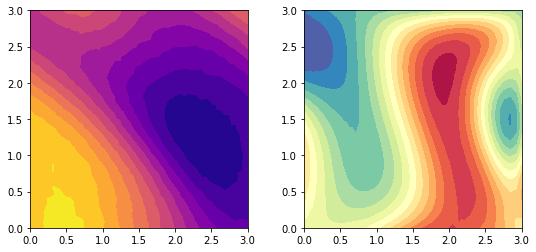

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4))

mtri = Triangulation(*quad_mesh.nodes.numpy().T)

vals = [f, u[:, 0]]
cm = ['plasma', 'Spectral']

for i, ax in enumerate(axes):
    cs = ax.tricontourf(mtri, vals[i], cmap=cm[i], levels=15)
    ax.set_aspect('equal')

plt.show()

In [11]:
from sklearn.datasets import fetch_species_distributions


In [12]:
def construct_grids(batch):
    """Construct the map grid from the batch object

    Parameters
    ----------
    batch : Batch object
        The object returned by :func:`fetch_species_distributions`

    Returns
    -------
    (xgrid, ygrid) : 1-D arrays
        The grid corresponding to the values in batch.coverages
    """
    # x,y coordinates for corner cells
    xmin = batch.x_left_lower_corner + batch.grid_size
    xmax = xmin + (batch.Nx * batch.grid_size)
    ymin = batch.y_left_lower_corner + batch.grid_size
    ymax = ymin + (batch.Ny * batch.grid_size)

    # x coordinates of the grid cells
    xgrid = np.arange(xmin, xmax, batch.grid_size)
    # y coordinates of the grid cells
    ygrid = np.arange(ymin, ymax, batch.grid_size)

    return (xgrid, ygrid)

# Get matrices/arrays of species IDs and locations
data = fetch_species_distributions()
species_names = ['Bradypus Variegatus', 'Microryzomys Minutus']

Xtrain = np.vstack([data['train']['dd lat'],
                    data['train']['dd long']]).T
ytrain = np.array([d.decode('ascii').startswith('micro')
                  for d in data['train']['species']], dtype='int')
#Xtrain *= np.pi / 180.  # Convert lat/long to radians

# Set up the data grid for the contour plot
xgrid, ygrid = construct_grids(data)

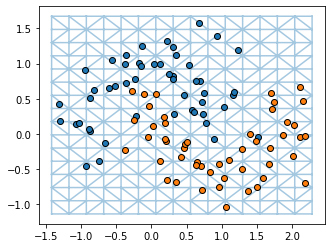

In [13]:
from scipy.spatial import Delaunay
from sklearn.datasets import make_moons

data = make_moons(noise=0.3, random_state=0)

X, y = data

bbox = (np.min(X[:, 0]) - 0.1, 
        np.max(X[:, 0]) + 0.1, 
        np.min(X[:, 1]) - 0.1, 
        np.max(X[:, 1]) + 0.1)

xx = np.linspace(bbox[0], bbox[1], 16)
yy = np.linspace(bbox[2], bbox[3], 16)

xx, yy = np.meshgrid(xx, yy)

nodes = np.column_stack((xx.ravel(), yy.ravel()))
tri = Delaunay(nodes)

tri_mesh = tenfem.mesh.TriangleMesh(tri.points, tri.simplices, tri.convex_hull, dtype=tf_dtype)
tri_mesh.add_matplotlib_tri()

fig, ax = plt.subplots()
ax.triplot(tri_mesh._triang, alpha=0.4)
ax.set_aspect('equal')
ax.plot(*X[y == 0].T, 'C0o', markeredgecolor='k')
ax.plot(*X[y == 1].T, 'C1o', markeredgecolor='k')
plt.show()

In [14]:
tfd = tfp.distributions

gp_layer = tfp.layers.VariationalGaussianProcess(
    num_inducing_points=num_inducing_points,
    kernel_provider=RBFKernelFn(),
    event_shape=[1],
    inducing_index_points_initializer=tf.constant_initializer(z),
    variational_inducing_observations_scale_initializer=tf.constant_initializer(scale),
    jitter=1e-4)

inputs = tfkl.Input(2)
x = tfkl.Dense(2)(inputs)  # scales inputs (like a length_scale)
f = tfkl.Dense(16, activation='relu')(x)
f = tfkl.Dense(16, activation='relu')(f)
pred = tfkl.Dense(2)(f)
#f = gp_layer(x)
#pred = tfpl.IndependentBernoulli(event_shape=(), convert_to_tensor_fn=tfd.Bernoulli.logits)(f)

model = tfk.Model(inputs=inputs, outputs=pred)

negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

model.summary()

model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics='accuracy')

NameError: name 'z' is not defined

In [ ]:
model.fit(X, y[:, None], batch_size=128, epochs=1000)

In [ ]:
pred = model.predict(tri_mesh.nodes)

In [ ]:
fig, ax = plt.subplots()
ax.contourf(xx, yy, pred[:, 0].reshape(xx.shape), cmap='Spectral')
ax.plot(*X[y == 0].T, 'C0o', markeredgecolor='k')
ax.plot(*X[y == 1].T, 'C1o', markeredgecolor='k')
ax.set_aspect('equal')
plt.show()

In [ ]:
y.shape[1:]

In [ ]:
fig, ax = plt.subplots()
ax.plot(*Xtrain.T, 'o', markeredgecolor='k')

In [ ]:
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > 0).ravel()

fig, ax = plt.subplots(figsize=(6, 10))
ax.contour(X, Y, land_reference,
            levels=[-9998], colors="k",
            linestyles="solid")

ax.plot(Xtrain[:, 1], Xtrain[:, 0], 'o', markeredgecolor='k')

ax.set_aspect('equal')

In [ ]:
plt.hist(land_reference)